# Forecast di serie storica univariata: Convolutional Neural Net con Multi-step

Utilizzeremo sempre il dataset Jena Climate. In questo primo esempio solo il dato sulla temperatura.

### Connessione al nostro Google Drive

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 594kB/s 


In [0]:
link = 'https://drive.google.com/yourlinkforsharing'
fluff, id = link.split('=')

print (id)

1cAWnNDGcdLUv55Qk-o2Fhc6toFVB-Vtg


### Caricamento dei dati

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('jena_climate_2009_2016.csv')

In [0]:
fname = 'jena_climate_2009_2016.csv'
f = open(fname)
data = f.read()
f.close

<function TextIOWrapper.close>

In [0]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [0]:
print(header)
print(len(header))
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
15
420551


### Parsing dei dati e creazione del vettore della serie storica

In [0]:
import numpy as np
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

Plot della serie storica completa

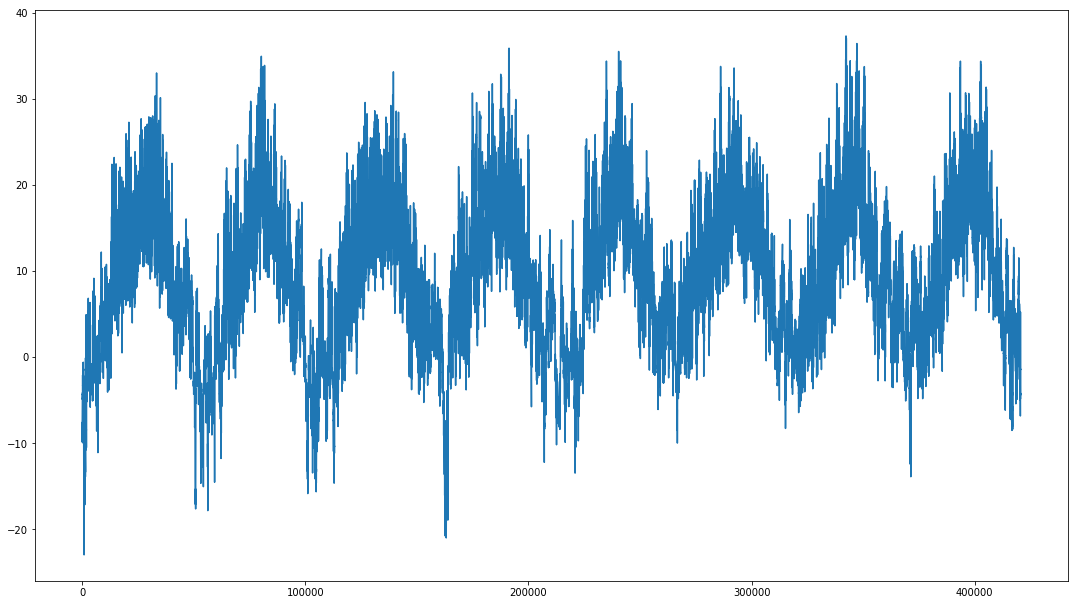

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
temp = float_data[:,1]
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(range(len(temp)), temp)

Plot dei primi dieci gioni

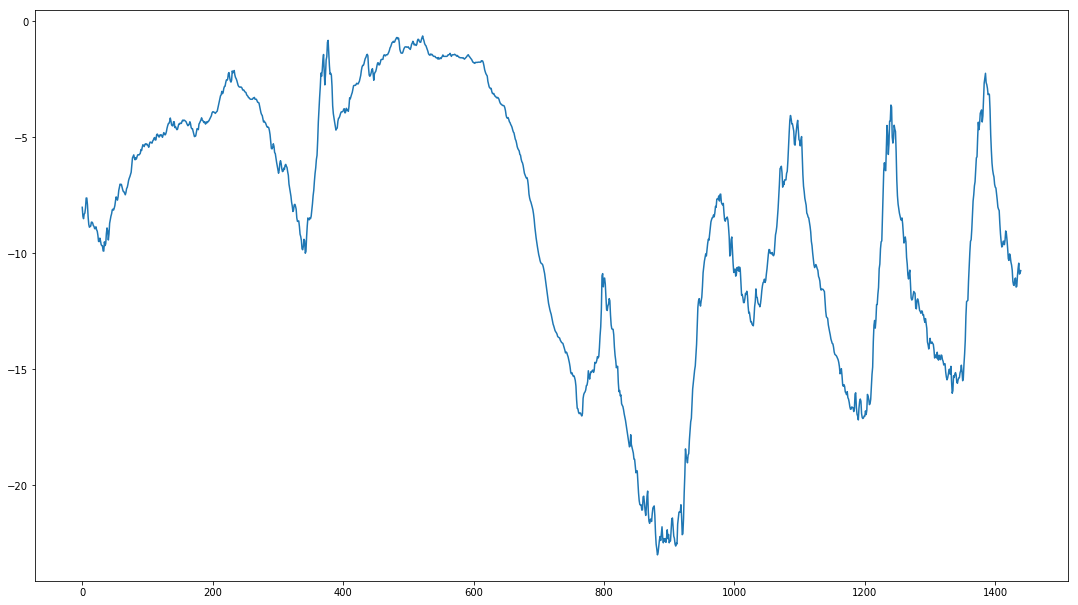

In [0]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(range(1440), temp[:1440])

In [0]:
temp_original = temp
temp = temp[:52560]

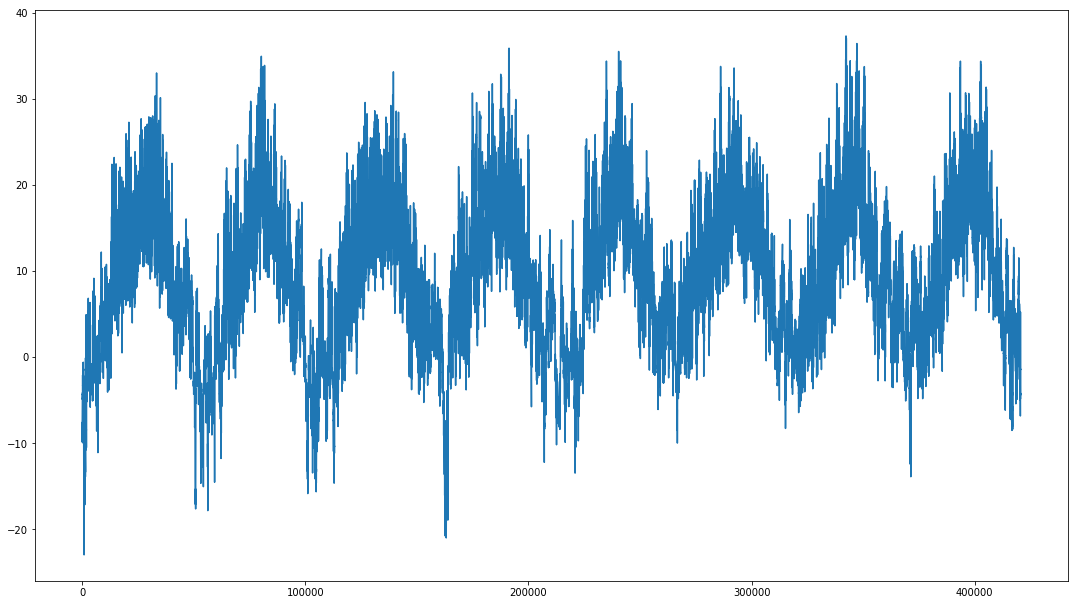

In [0]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(range(len(temp)), temp)

### Preprocessing

Tengo il 70% delle osservazioni per allenare il modello (il 30% di queste verrà utilizzato come validation) e il restante 30% lo utilizzeremo per il test.

In [0]:
train_size = int(len(temp) * 0.90)

In [0]:
train = temp[:train_size]
test = temp[train_size:]

Bisogna creare delle sequenze input/output dove gli N valori precedenti vanno a predire il successivo. Al momento in output inseriamo un valore solo ma è possibile anche lavorare in multi-step.
<br>
La funzione ***split_sequence()*** serve a questo bisogno, creare delle finestre temporali.

In [0]:
# split a univariate sequence into samples
def split_sequence_multistep(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

Avendo dati a 10 minuti vogliamo predire considerando l'ora precedente quindi il parametro *n_steps* verrà impostato a 6.

In [0]:
n_steps_in = 6
n_steps_out = 3
train_x, train_y = split_sequence_multistep(sequence= train, n_steps_in= n_steps_in, n_steps_out = n_steps_out)
test_x, test_y = split_sequence_multistep(sequence= test, n_steps_in= n_steps_in, n_steps_out = n_steps_out)

Vediamo i primi 10 elementi del train per capire il formato.

In [0]:
for i in range(10):
	print(train_x[i], train_y[i])

[-8.02 -8.41 -8.51 -8.31 -8.27 -8.05] [-7.62 -7.62 -7.91]
[-8.41 -8.51 -8.31 -8.27 -8.05 -7.62] [-7.62 -7.91 -8.43]
[-8.51 -8.31 -8.27 -8.05 -7.62 -7.62] [-7.91 -8.43 -8.76]
[-8.31 -8.27 -8.05 -7.62 -7.62 -7.91] [-8.43 -8.76 -8.88]
[-8.27 -8.05 -7.62 -7.62 -7.91 -8.43] [-8.76 -8.88 -8.85]
[-8.05 -7.62 -7.62 -7.91 -8.43 -8.76] [-8.88 -8.85 -8.83]
[-7.62 -7.62 -7.91 -8.43 -8.76 -8.88] [-8.85 -8.83 -8.66]
[-7.62 -7.91 -8.43 -8.76 -8.88 -8.85] [-8.83 -8.66 -8.66]
[-7.91 -8.43 -8.76 -8.88 -8.85 -8.83] [-8.66 -8.66 -8.7 ]
[-8.43 -8.76 -8.88 -8.85 -8.83 -8.66] [-8.66 -8.7  -8.81]


### Model: Univariate CNN

Creiamo una rete abbastanza semplice e sperimentiamo diversi tuning.

In [0]:
!pip install -U -q tensorflow

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout

## RETE CONVOLUZIONALE 1D



In [0]:
train_x.shape

(378487, 6)

In [0]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], n_features))

In [0]:
train_x.shape

(378487, 6, 1)

In [0]:
model = Sequential(name= 'CNN-test1')
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [0]:
history = model.fit(train_x, train_y, epochs=10, batch_size=8, steps_per_epoch= 32, validation_split=0.3)

Epoch 1/10
32/32 [==============================] - 41s 1s/step - loss: 54.3954 - val_loss: 2.0814
Epoch 2/10
32/32 [==============================] - 41s 1s/step - loss: 1.4911 - val_loss: 0.8021
Epoch 3/10
32/32 [==============================] - 41s 1s/step - loss: 0.7170 - val_loss: 0.7095
Epoch 4/10
32/32 [==============================] - 42s 1s/step - loss: 0.6894 - val_loss: 0.6924
Epoch 5/10
32/32 [==============================] - 41s 1s/step - loss: 0.6695 - val_loss: 0.6693
Epoch 6/10
32/32 [==============================] - 41s 1s/step - loss: 0.6422 - val_loss: 0.6354
Epoch 7/10
32/32 [==============================] - 41s 1s/step - loss: 0.5951 - val_loss: 0.5736
Epoch 8/10
32/32 [==============================] - 41s 1s/step - loss: 0.5242 - val_loss: 0.4955
Epoch 9/10
32/32 [==============================] - 41s 1s/step - loss: 0.4496 - val_loss: 0.4259
Epoch 10/10
32/32 [==============================] - 41s 1s/step - loss: 0.3931 - val_loss: 0.3840


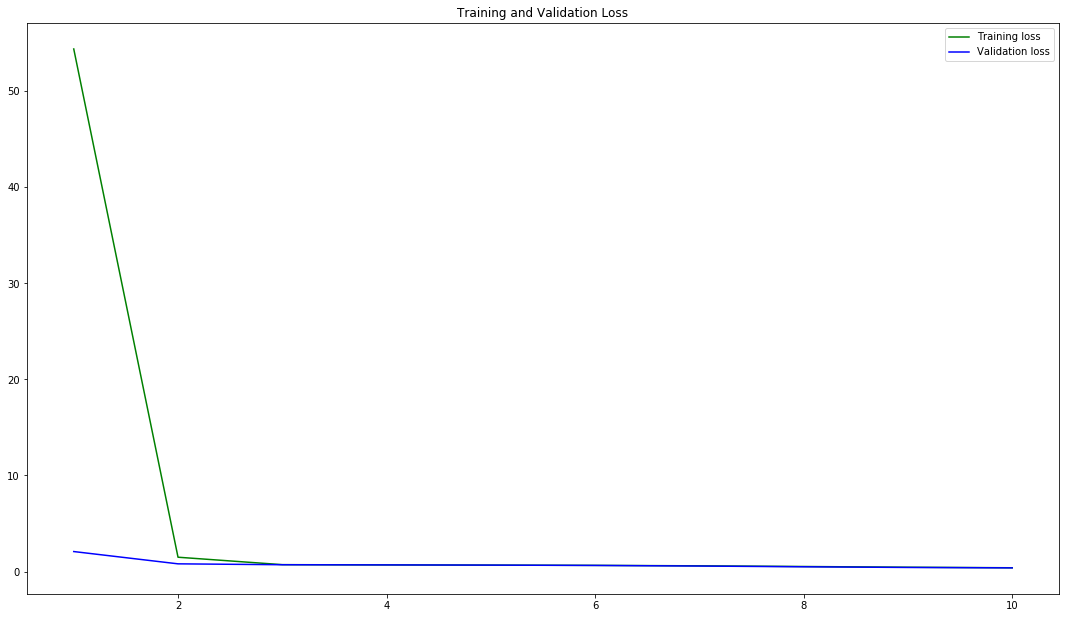

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(epochs, loss, 'b', color='green', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', color = 'blue', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

Testiamo una seconda configurazione con più epoche e un diverso setting dei parametri, inseriamo anche lo shuffle.

In [0]:
trainScore = model.evaluate(train_x, train_y, batch_size=8,verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(test_x, test_y, batch_size=8, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Train Score: 0.38 MSE (0.61 RMSE)
Test Score: 0.38 MSE (0.62 RMSE)


In [0]:
trainPredict = model.predict(train_x, batch_size= 8)
testPredict = model.predict(test_x, batch_size=8)

In [0]:
testPredict

array([[ 2.6547666,  2.6422431,  2.6691926],
       [ 2.5891688,  2.5761516,  2.6059406],
       [ 2.5380192,  2.5248244,  2.5506134],
       ...,
       [-4.164422 , -4.0610948, -4.1693945],
       [-3.685904 , -3.5162253, -3.590202 ],
       [-3.7431989, -3.682615 , -3.6700153]], dtype=float32)

### Validazione numerica

Confrontiamo i primi 10 valori predetti e reali

In [0]:
testPredict[:10]

array([[2.6547666, 2.6422431, 2.6691926],
       [2.5891688, 2.5761516, 2.6059406],
       [2.5380192, 2.5248244, 2.5506134],
       [2.4815142, 2.4727538, 2.4963002],
       [2.4399729, 2.4289422, 2.4553068],
       [2.372288 , 2.3589997, 2.3859868],
       [2.2665286, 2.2532558, 2.277821 ],
       [2.1812112, 2.174341 , 2.192596 ],
       [2.1006596, 2.093766 , 2.116646 ],
       [2.0146694, 2.0020914, 2.026439 ]], dtype=float32)

In [0]:
test_y[:10]

array([[2.58, 2.53, 2.46],
       [2.53, 2.46, 2.36],
       [2.46, 2.36, 2.3 ],
       [2.36, 2.3 , 2.22],
       [2.3 , 2.22, 2.12],
       [2.22, 2.12, 2.  ],
       [2.12, 2.  , 1.93],
       [2.  , 1.93, 1.85],
       [1.93, 1.85, 1.8 ],
       [1.85, 1.8 , 1.8 ]])